<a href="https://colab.research.google.com/github/utsav-195/covid-19-detection-using-cnn/blob/master/COVID_19_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COVID-19 Pneumonia Detection using CNN

---




Models
1. SVM
2. Multi_layer Perceptron
3. Resnet50
4. VGG-19

In [0]:
# Importing data from the drve
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip "/content/drive/My Drive/covid19-radiography-database.zip"

In [0]:
# importing the required libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.metrics import accuracy_score

In [0]:
# loading in the images
covid_files_before_aug = os.listdir('/content/COVID-19 Radiography Database/COVID-19/')
normal_files_before_aug = os.listdir('/content/COVID-19 Radiography Database/NORMAL/')
viral_files_before_aug = os.listdir('/content/COVID-19 Radiography Database/Viral Pneumonia/')

In [0]:
# printing the total number of images
len(covid_files_before_aug)

1293

Text(0.5, 1.0, 'Initial Class Distibution- Before Augmentation')

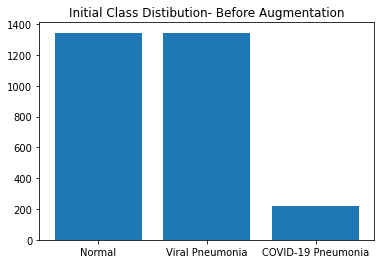

In [0]:
# plotting the number of images in each class
y=[len(normal_files_before_aug) , len(viral_files_before_aug), len(covid_files_before_aug)]
x=["Normal","Viral Pneumonia", "COVID-19 Pneumonia" ]
plt.bar(x,y)
plt.title("Initial Class Distibution- Before Augmentation")

The above graph clearly shows a class imbalancce which needs to be corrected by data augmentation before training 

Text(0.5, 1.0, 'Images showing x-rays for a) No Pneumonia b) Viral Pneumonia c) COVID-19 Pneumonia')

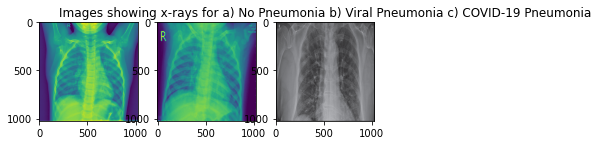

In [0]:
covid_im = imageio.imread('/content/COVID-19 Radiography Database/COVID-19/COVID-19 (1).png')
normal_im = imageio.imread('/content/COVID-19 Radiography Database/NORMAL/NORMAL (1).png')
viral_im = imageio.imread('/content/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1).png')
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(normal_im)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(viral_im)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(covid_im)
plt.title("Images showing x-rays for a) No Pneumonia b) Viral Pneumonia c) COVID-19 Pneumonia")

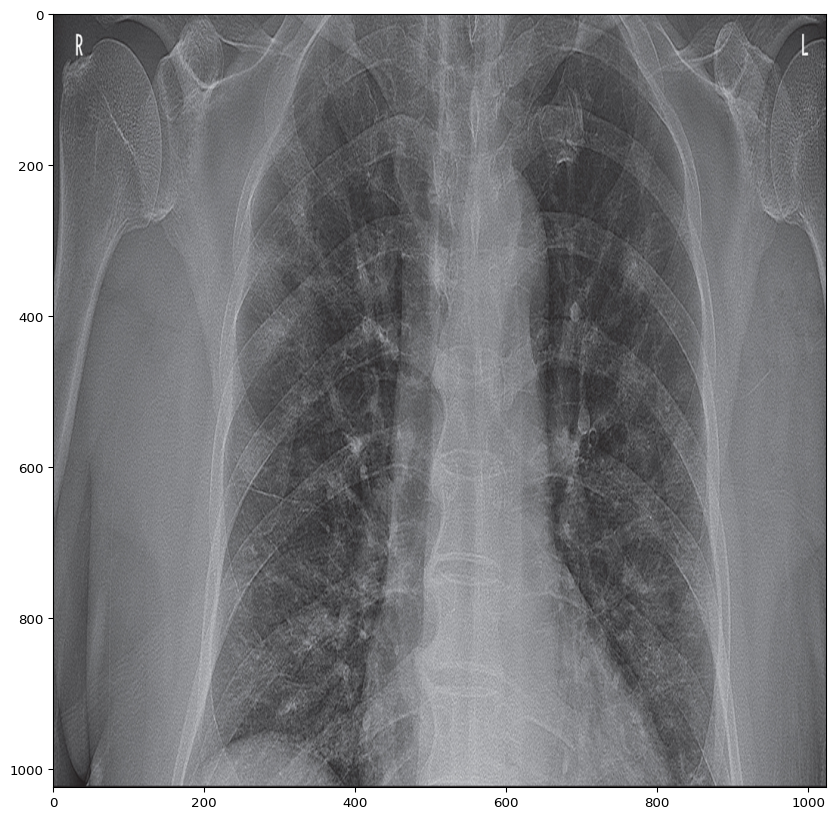

In [0]:
# displaying the first image
image = covid_im
ia.imshow(image)

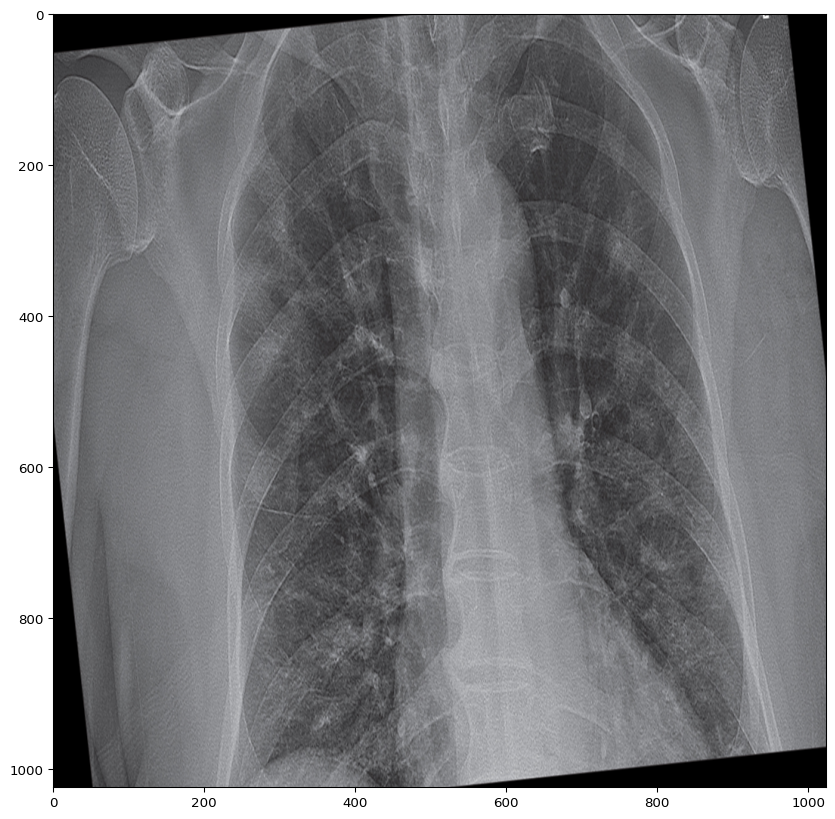

In [0]:
# Rotated image, will be used for data augmentation
# takes a random value in degrees between the specified range
rotate=iaa.Affine(rotate=(-30, 30))
rotated_image=rotate.augment_image(image)
ia.imshow(rotated_image)

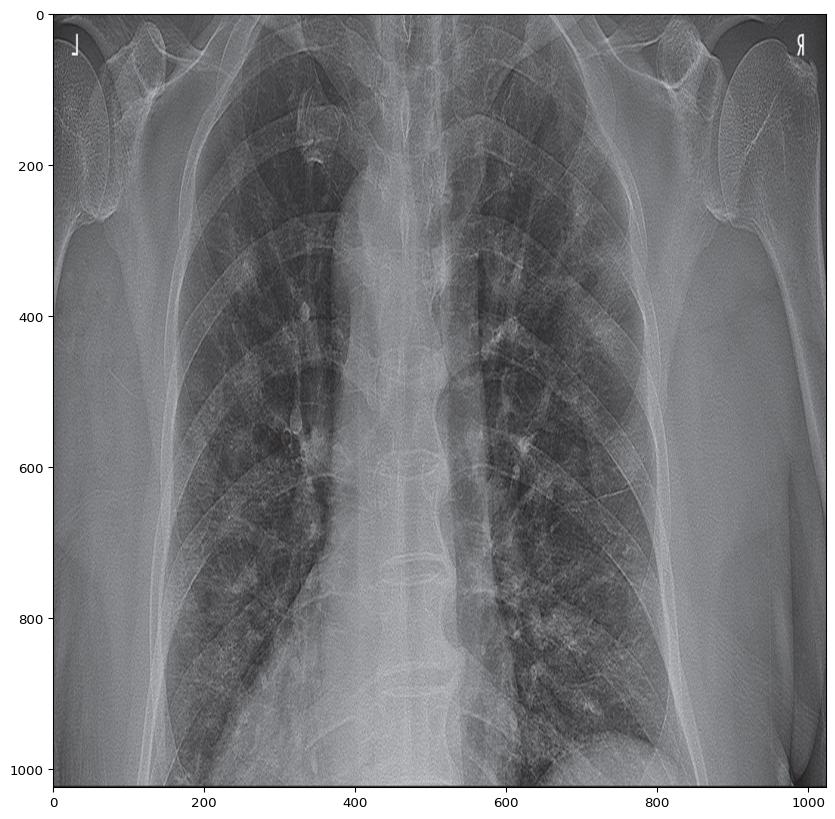

In [0]:
# mirrored image, will be used for data augmentation
mirrored_image = image[:,::-1]
ia.imshow(mirrored_image)

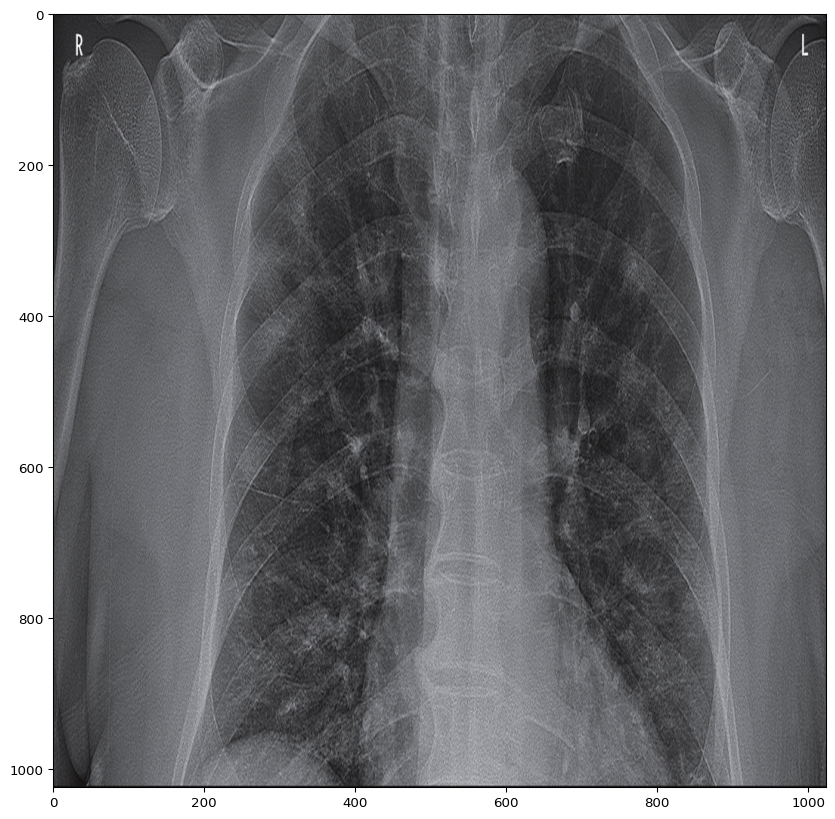

In [0]:
# incrasing the contrast of the image, will be used for data augmentation
contrast=iaa.GammaContrast(gamma=1.25)
contrast_image =contrast.augment_image(image)
ia.imshow(contrast_image)

In [0]:
# Data augmentation for COVID-19 images
folder = '/content/COVID-19 Radiography Database/COVID-19/'

for file in covid_files_before_aug[40:]:
  filepath = folder + file
  # read data of the image
  image = imageio.imread(filepath)

  # mirror and save the image
  mirrored_image = image[:,::-1]
  filename = folder + file.split(".")[0] + "_mirrored.png"
  cv2.imwrite(filename, mirrored_image)

  # contrast and save the image
  contrast = iaa.GammaContrast(gamma=1.1)
  contrast_image = contrast.augment_image(image)
  filename = folder + file.split(".")[0] + "_contrasted_125.png"
  cv2.imwrite(filename, contrast_image)

  contrast = iaa.GammaContrast(gamma=1.2)
  contrast_image = contrast.augment_image(image)
  filename = folder + file.split(".")[0] + "_contrasted_140.png"
  cv2.imwrite(filename, contrast_image)

  # create 3 rotated images and save them
  for i in range(3):
    rotate = iaa.Affine(rotate=(-30, 30))
    rotated_image = rotate.augment_image(image)
    filename = folder + file.split(".")[0] + "_rotated_"+str(i)+".png"
    cv2.imwrite(filename, rotated_image)

In [0]:
# after augmentation of COVID-19 images, approximately the same number of data points for each type
covid_files_test = covid_files_before_aug[:40]
covid_files = os.listdir('/content/COVID-19 Radiography Database/COVID-19/')
covid_files_train = []
for files in covid_files:
  # searating the testing data set
  if files not in covid_files_test:
    covid_files_train.append(files)
print(len(covid_files))

normal_files = os.listdir('/content/COVID-19 Radiography Database/NORMAL/')
# searating the testing data set
normal_files_test = normal_files[:40]
print(len(normal_files))

viral_files = os.listdir('/content/COVID-19 Radiography Database/Viral Pneumonia/')
# searating the testing data set
viral_files_test = viral_files[:40]
print(len(viral_files))

1293
1341
1345


Text(0.5, 1.0, 'Class Distibution After Augmentation')

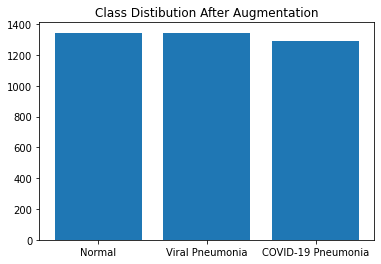

In [0]:
# plotting the number of  images in each class after augmentation
y=[len(normal_files) , len(viral_files), len(covid_files)]
x=["Normal","Viral Pneumonia", "COVID-19 Pneumonia" ]
plt.bar(x,y)
plt.title("Class Distibution After Augmentation")

From the above graph it is clear that the class imbalance is corrected as each class has approximately the same number of images.

In [0]:
# create a combined dataset
# Label Encoding 0:Covid, 1:Normal, Viral:2

# trainig dataset
data_train = []
covid_folder = "/content/COVID-19 Radiography Database/COVID-19/"
for files in covid_files_train[60:]:
  filepath = covid_folder + files
  data_train.append([filepath,0])

normal_folder = "/content/COVID-19 Radiography Database/NORMAL/"
for files in normal_files[100:]:
  filepath = normal_folder + files
  data_train.append([filepath,1])

viral_folder = "/content/COVID-19 Radiography Database/Viral Pneumonia/"
for files in viral_files[100:]:
  filepath = viral_folder + files
  data_train.append([filepath,2])

# validation dataset
# separating 60 images from each class for validation
data_val = []
covid_folder = "/content/COVID-19 Radiography Database/COVID-19/"
for files in covid_files_train[:60]:
  filepath = covid_folder + files
  data_val.append([filepath,0])

normal_folder = "/content/COVID-19 Radiography Database/NORMAL/"
for files in normal_files[40:100]:
  filepath = normal_folder + files
  data_val.append([filepath,1])

viral_folder = "/content/COVID-19 Radiography Database/Viral Pneumonia/"
for files in viral_files[40:100]:
  filepath = viral_folder + files
  data_val.append([filepath,2])

# testing dataset
# separating 40 images from each class for testing
data_test = []
covid_folder = "/content/COVID-19 Radiography Database/COVID-19/"
for files in covid_files_test:
  filepath = covid_folder + files
  data_test.append([filepath,0])

normal_folder = "/content/COVID-19 Radiography Database/NORMAL/"
for files in normal_files_test:
  filepath = normal_folder + files
  data_test.append([filepath,1])

viral_folder = "/content/COVID-19 Radiography Database/Viral Pneumonia/"
for files in viral_files_test:
  filepath = viral_folder + files
  data_test.append([filepath,2])

In [0]:
dataframe = pd.DataFrame(data_train, columns=['filepath','label'])
dataframe.to_csv("/content/COVID-19 Radiography Database/data_train.csv")

dataframe = pd.DataFrame(data_val, columns=['filepath','label'])
dataframe.to_csv("/content/COVID-19 Radiography Database/data_val.csv")

dataframe = pd.DataFrame(data_test, columns=['filepath','label'])
dataframe.to_csv("/content/COVID-19 Radiography Database/data_test.csv")

In [0]:
df_train = pd.read_csv("/content/COVID-19 Radiography Database/data_train.csv",index_col=0)
print(df_train.shape)
df_val = pd.read_csv("/content/COVID-19 Radiography Database/data_val.csv",index_col=0)
print(df_val.shape)
df_test = pd.read_csv("/content/COVID-19 Radiography Database/data_test.csv",index_col=0)
print(df_test.shape)
df_train = df_train.sample(frac=1).reset_index(drop=True)
print(df_train.head())
df_val = df_val.sample(frac=1).reset_index(drop=True)
print(df_val.head())

(3679, 2)
(180, 2)
(120, 2)
                                            filepath  label
0  /content/COVID-19 Radiography Database/Viral P...      2
1  /content/COVID-19 Radiography Database/NORMAL/...      1
2  /content/COVID-19 Radiography Database/Viral P...      2
3  /content/COVID-19 Radiography Database/NORMAL/...      1
4  /content/COVID-19 Radiography Database/Viral P...      2
                                            filepath  label
0  /content/COVID-19 Radiography Database/COVID-1...      0
1  /content/COVID-19 Radiography Database/COVID-1...      0
2  /content/COVID-19 Radiography Database/COVID-1...      0
3  /content/COVID-19 Radiography Database/NORMAL/...      1
4  /content/COVID-19 Radiography Database/COVID-1...      0


# Implementation of Baseline Classifiers

In [0]:
from keras.preprocessing import image
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras import regularizers

The SVM model requires an input of n_samples,n_features.

The input images were preprocessed to convert them to the required format. The image loaded as 224,224,3 was transposed and reshaped to be 1,150528

In [0]:
train_imgs_svm = [image.img_to_array(image.load_img(img, target_size=(224, 224))).transpose(2,0,1).reshape(1,-1)[0] for img in df_train.filepath]
print(np.asarray(train_imgs_svm).shape)

(3679, 150528)


In [0]:
test_imgs_svm = [image.img_to_array(image.load_img(img, target_size=(224, 224))).transpose(2,0,1).reshape(1,-1)[0] for img in df_test.filepath]
print(np.asarray(test_imgs_svm).shape)

(120, 150528)


In [0]:
from sklearn.svm import SVC

svm = SVC(C=100,kernel='rbf')

svm.fit(train_imgs_svm,df_train.label)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
preds = svm.predict(test_imgs_svm)
print(accuracy_score(df_test.label,preds))

0.9333333333333333


The MLP algorithm also expects an input of n_samples,n_features. So, the same input vector and test vector used for SVM was used for training and testing resp.

In [0]:
from sklearn.neural_network import MLPClassifier

model_nn = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,100), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, max_iter=10000, shuffle=True, momentum=0.9, early_stopping=True, epsilon=1e-08)

model_nn.fit(train_imgs_svm,df_train.label)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100),
              learning_rate='adaptive', learning_rate_init=0.001, max_fun=15000,
              max_iter=10000, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [0]:
preds = model_nn.predict(test_imgs_svm)
print(accuracy_score(df_test.label,preds))

0.925


# Implementation of Deep Learning Models

Implementing the ResetNet-50

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

# using the weights obtained by training on the imagenet dataset
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224,3))
output = resnet.layers[-1].output
output = Flatten()(output)
resnet = Model(resnet.input, output=output)

# freezing the weights of the non-fully connected layer
for layer in resnet.layers:
    layer.trainable = False

resnet.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  after removing the cwd from sys.path.


Adding custom fully connected layer for training

In [0]:
model_resnet = Sequential()
model_resnet.add(resnet)
model_resnet.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(Dropout(0.3))
model_resnet.add(Dense(3, activation='softmax',kernel_regularizer=regularizers.l2(0.01)))
model_resnet.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])
model_resnet.summary()

Preprocessing the images to be of the expected format of Resnet-50 model

In [0]:
train_imgs = [image.img_to_array(image.load_img(img, target_size=(224, 224))) for img in df_train.filepath]
train_imgs = np.expand_dims(train_imgs, axis=0)
train_imgs = preprocess_input(train_imgs)

val_imgs = [image.img_to_array(image.load_img(img, target_size=(224, 224))) for img in df_val.filepath]
val_imgs = np.expand_dims(val_imgs, axis=0)
val_imgs = preprocess_input(val_imgs)

test_imgs = [image.img_to_array(image.load_img(img, target_size=(224, 224))) for img in df_test.filepath]
test_imgs = np.expand_dims(test_imgs, axis=0)
test_imgs = preprocess_input(test_imgs)

Encoding the labels into one hot encoded vectors

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

y_train = df_train.label
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_Y)
# print(y_train)

y_val = df_val.label
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_val)
encoded_Y = encoder.transform(y_val)

# convert integers to dummy variables (i.e. one hot encoded)
y_val = np_utils.to_categorical(encoded_Y)
# print(y_val)

In [0]:
!mkdir /model

Training the model

In [0]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

# adding a check pointer to save the best model
checkpointer = ModelCheckpoint(filepath='/model/resnet_weights.h5', verbose=1, save_best_only=True)

# datetime object containing current date and time
now = datetime.now()

dt_string = now.strftime("%d-%m-%Y-%H-%M-%S")
print("now =", dt_string)

history = model_resnet.fit(x=train_imgs[0],
                    y=y_train,
                    epochs=100,
                    validation_data=(val_imgs[0],y_val),
                    shuffle=True,
                    callbacks=[checkpointer],
                    verbose=1)

# model_resnet.save('/model/resnet50_model_'+dt_string+'.h5')
print("done")

now = 02-05-2020-16-19-13
Train on 3679 samples, validate on 180 samples
Epoch 1/100
3679/3679 [==============================] - 57s 16ms/step - loss: 7.1735 - accuracy: 0.9225 - val_loss: 4.8376 - val_accuracy: 0.7222

Epoch 00001: val_loss improved from inf to 4.83761, saving model to /model/weights.h5
Epoch 2/100
3679/3679 [==============================] - 46s 13ms/step - loss: 2.1360 - accuracy: 0.9644 - val_loss: 1.7380 - val_accuracy: 0.9167

Epoch 00002: val_loss improved from 4.83761 to 1.73805, saving model to /model/weights.h5
Epoch 3/100
3679/3679 [==============================] - 46s 13ms/step - loss: 1.2535 - accuracy: 0.9698 - val_loss: 1.7325 - val_accuracy: 0.8778

Epoch 00003: val_loss improved from 1.73805 to 1.73247, saving model to /model/weights.h5
Epoch 4/100
3679/3679 [==============================] - 46s 13ms/step - loss: 0.9326 - accuracy: 0.9720 - val_loss: 5.3460 - val_accuracy: 0.5111

Epoch 00004: val_loss did not improve from 1.73247
Epoch 5/100
3679/3

Using the best model saved by the checkpointer for testing

In [0]:
reconstructed_model = load_model('/model/resnet_weights.h5')

preds = reconstructed_model.predict_classes(test_imgs[0])

print(accuracy_score(df_test.label,preds))

0.9416666666666667


Using the model that has gone through all epochs of training

In [0]:
preds = model_resnet.predict_classes(test_imgs[0])
print(accuracy_score(df_test.label,preds))

0.925


Implementing the VGG-19 model

In [0]:
from keras.applications.vgg19 import VGG19

# loading the weights of the model trained on the imagenet dataset
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224,3))
output = vgg19.layers[-1].output
output = Flatten()(output)
vgg19 = Model(vgg19.input, output=output)

# freezing the weights of the no-fully-connected layer
for layer in vgg19.layers:
    layer.trainable = False

vgg19.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  if __name__ == '__main__':


Adding a cutom fully connected layer for training

In [0]:
model_vgg19 = Sequential()
model_vgg19.add(vgg19)
model_vgg19.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_vgg19.add(Dropout(0.3))
model_vgg19.add(Dense(3, activation='softmax',kernel_regularizer=regularizers.l2(0.01)))
model_vgg19.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])
model_vgg19.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 25088)             20024384  
_________________________________________________________________
dense_11 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 771       
Total params: 26,447,939
Trainable params: 6,423,555
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

# checkpointer to save the best model
checkpointer_v = ModelCheckpoint(filepath='/model/vgg_weights.h5', verbose=1, save_best_only=True)

# datetime object containing current date and time
now = datetime.now()

dt_string = now.strftime("%d-%m-%Y-%H-%M-%S")
print("Time: ", dt_string)

history = model_vgg19.fit(x=train_imgs[0],
                    y=y_train,
                    epochs=50,
                    validation_data=(val_imgs[0],y_val),
                    shuffle=True,
                    callbacks=[checkpointer_v],
                    verbose=1)

# model_resnet.save('/model/vgg_model_'+dt_string+'.h5')
print("done")

now = 04-05-2020-18-08-37
Train on 3679 samples, validate on 180 samples
Epoch 1/50
3679/3679 [==============================] - 42s 11ms/step - loss: 5.0008 - accuracy: 0.9084 - val_loss: 2.7816 - val_accuracy: 0.9722

Epoch 00001: val_loss improved from inf to 2.78163, saving model to /model/weightsvgg.h5
Epoch 2/50
3679/3679 [==============================] - 42s 11ms/step - loss: 2.0540 - accuracy: 0.9663 - val_loss: 1.3058 - val_accuracy: 0.9778

Epoch 00002: val_loss improved from 2.78163 to 1.30582, saving model to /model/weightsvgg.h5
Epoch 3/50
3679/3679 [==============================] - 42s 11ms/step - loss: 1.2346 - accuracy: 0.9717 - val_loss: 0.8419 - val_accuracy: 0.9889

Epoch 00003: val_loss improved from 1.30582 to 0.84189, saving model to /model/weightsvgg.h5
Epoch 4/50
3679/3679 [==============================] - 42s 11ms/step - loss: 0.9543 - accuracy: 0.9796 - val_loss: 0.7805 - val_accuracy: 0.9944

Epoch 00004: val_loss improved from 0.84189 to 0.78047, saving m

Using the best model from the vgg training for testing

In [0]:
reconstructed_vgg = load_model('/model/vgg_weights.h5')
predictions_vgg = reconstructed_vgg.predict_classes(test_imgs[0])
print(accuracy_score(df_test.label,predictions_vgg))

0.975


### Note: For more details about different experiments and thought process please check the [Project Report.pdf](https://github.com/utsav-195/covid-19-detection-using-cnn/blob/master/Project%20Report.pdf)